# MDS Bewertung

## Hilfunktionen

In [1]:
import ipynb.fs.full.mds_function as my_mds

In [2]:
def prepare_data(df, data_model='production'):
    df = my_mds.resolve_similarity_if_necassary(df, data_model=data_model)
    data = my_mds.transform_to_pivot(df, data_model=data_model)
    precomputed_data = my_mds.transform_to_D(df)
    meta_data = my_mds.extract_metadata(data, data_model=data_model)
    return df, data, precomputed_data, meta_data


In [3]:
def get_init_configuration(data, meta_data, data_model ='production', plot=True, flowrack_aisle=None, aisle=None):
    if data_model == 'simulation':
        init_configuration =  my_mds.init_from_blender(num_aisle=aisle)
    else:
        init_configuration = my_mds.create_init_configuration(data, data_model=data_model, flowrack_aisle=flowrack_aisle)
    init_data = my_mds.merge_data(init_configuration, meta_data)
    if plot:
        my_mds.plot_3dmodel(init_data, data_model=data_model, plot_color_base='aisle', plot_line=True, print_label=False, print_base=True, annotate_base=True)
    return init_configuration

In [4]:
def weights_due_shelfs_in_aisle(data, weight_factor=0.5, old_weights=None):
    import numpy as np
    data['weights'] = 1
    data.loc[((data.source_aisle == data.target_aisle) & (data.source_shelf % 2  != data.target_shelf % 2) & (data.source_location != "Base") & (data.target_location != "Base")), 'weights'] = weight_factor
    weights = my_mds.transform_to_D(data, feature="weights")
    if old_weights is None:
        old_weights = np.ones(weights.shape)
    return weights*old_weights

In [5]:
def plot_shepard(obs, mds_conf, plot=True):
	from sklearn.model_selection import train_test_split
	from sklearn.linear_model import LinearRegression
	from sklearn.metrics.pairwise import euclidean_distances
	import matplotlib.pyplot as plt
	import numpy as np
	d_mds = euclidean_distances(mds_conf).ravel()
	d_obs = euclidean_distances(obs).ravel() if (obs.shape[0] != obs.shape[1]) else obs.ravel()
	if plot:
		f, ax = plt.subplots()
		ax.plot(d_obs, d_mds, '*', markersize=2)

	X = np.column_stack((np.ones(len(d_obs)), d_obs))
	Y = d_mds
	B = np.linalg.solve(X.T.dot(X), X.T.dot(Y))
	linPreds = B[0] + B[1]*d_obs
	
	X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 6767)
	regressor = LinearRegression()
	regressor.fit(X_train, y_train)
	R2 = regressor.score(X,Y)
	#R2 = 1 - ((d_mds - linPreds)**2).sum() / ((d_mds-d_obs)**2).sum()
	if plot:
		o = d_obs.argsort()
		ax.plot(d_obs[o], linPreds[o], c='r', lw=2)
		ax.text(0.05, 0.85, r'$R^2$ = {:.3}'.format(R2), ha='left', va='center', transform=ax.transAxes)
		plt.show()
	return round(R2,3)

In [6]:
def plot_and_compute_mds_configuration(df, precomputed_data, init_configuration, meta_data, 
                                       weight_function=None, 
                                       old_weights=None, 
                                       plot_line=False, 
                                       plot_color_base='aisle', 
                                       shepard=False, 
                                       data_model='production',
                                       print_base=True, 
                                       weight_factor=None,
                                       plot=True):
    import numpy as np

    if weight_function is not None:
        weights = weight_function(df, old_weights=old_weights, weight_factor=weight_factor)
    else:
        weights = None

    co3d, mds = my_mds.perform_sklearn_mds(precomputed_data, init=init_configuration, weights=weights)
    data = my_mds.merge_data(co3d, meta_data)
    
    if init_configuration is not None:
        stress_1 = round(my_mds.calc_stress_1(co3d, init_data=init_configuration),3)
    else:
        stress_1 = round(my_mds.calc_stress_1(co3d, init_data=precomputed_data),3)
    
    if plot:
        my_mds.plot_3dmodel(data, data_model=data_model, 
                        plot_color_base=plot_color_base, 
                        plot_line=plot_line, 
                        print_label=False, 
                        print_base=print_base, 
                        annotate_base=True, 
                        add_text=[r'\sigma_{\rm 1}', stress_1])

    if shepard:
        r2 = plot_shepard(precomputed_data if init_configuration is None else init_configuration, co3d, plot=plot)
    else:
        r2 = None

    return np.array([stress_1, r2])


## RQ 1
*Inwieweit lässt sich aus Bewegungsdaten, die während eines Kommissioniervorganges gesammelt werden, ein realitätsnahes Modell eines manuellen Lagerbereiches rekonstruieren.*

### Analyse
Zur Analyse wird das Testbsp., ein Simulationsmodell und ein Produktionsmodell verglichen

### Testbeispiel


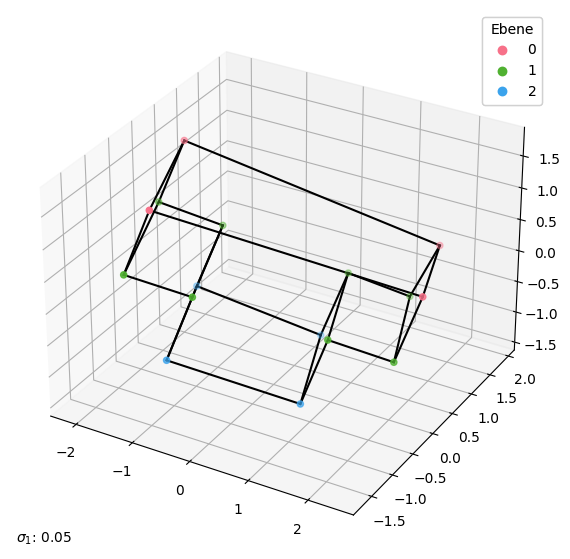

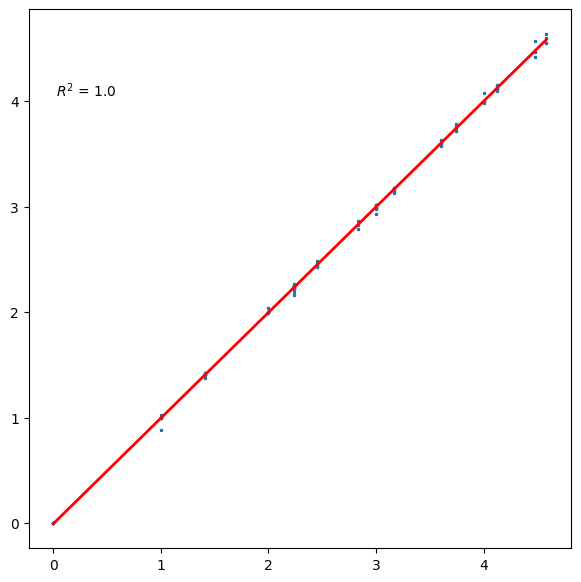

In [7]:
df_test = my_mds.import_pickle_dataset('data/test_data.pkl')
df_test, data_test, precomputed_data_test, meta_data_test= prepare_data(df_test, data_model='test')
metrics_test = plot_and_compute_mds_configuration(df_test, precomputed_data_test, None, meta_data_test, plot_line=True, print_base=False, shepard=True, data_model='test', plot_color_base='level')


### Simulationsmodell mit 16 Lagerplätze über 2 Gänge

In [8]:
df_sim_16 = my_mds.import_pickle_dataset('data/simulation_data_1_aisle_return_16_loc_all.pkl')
wp_sim_16 = my_mds.get_num_wp_according_locations(df_sim_16)

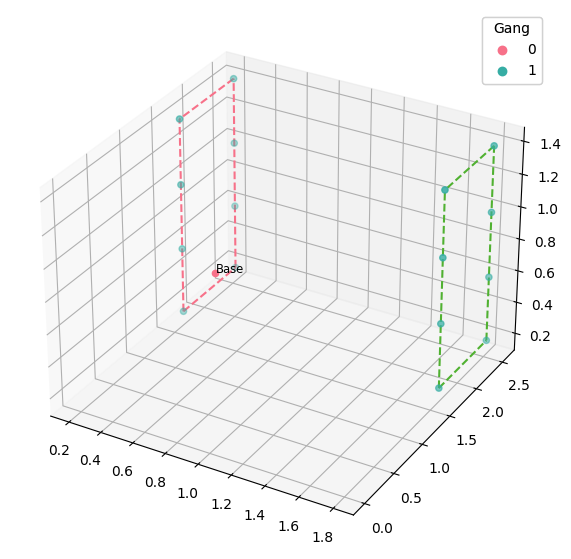

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


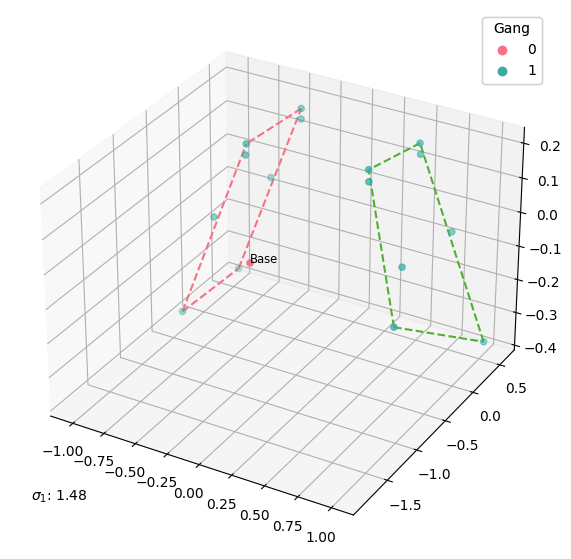

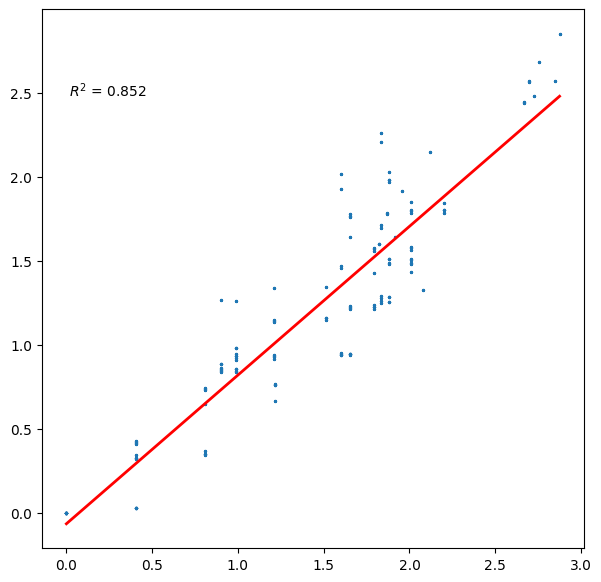

In [9]:
df_sim_16, data_sim_16, precomputed_data_sim_16, meta_data_sim_16= prepare_data(df_sim_16, data_model='simulation')
init_configuration_aisle_2 = get_init_configuration(data_sim_16, meta_data_sim_16, data_model ='simulation', aisle=1)
metrics_sim_16 = plot_and_compute_mds_configuration(df_sim_16, precomputed_data_sim_16, init_configuration_aisle_2, meta_data_sim_16,
                                                    weight_function=weights_due_shelfs_in_aisle, 
                                                    plot_line=True, 
                                                    shepard=True, 
                                                    weight_factor=0)


### Live-Modell

In [10]:
df_prod = my_mds.import_pickle_dataset('data/production_data_less_pieces_369021.pkl').query('source_aisle != 1 and target_aisle != 1')
wp_prod = my_mds.get_num_wp_according_locations(df_prod)

Warning - not a square matrix most likely due to missing observations - add zero distances for missing observations


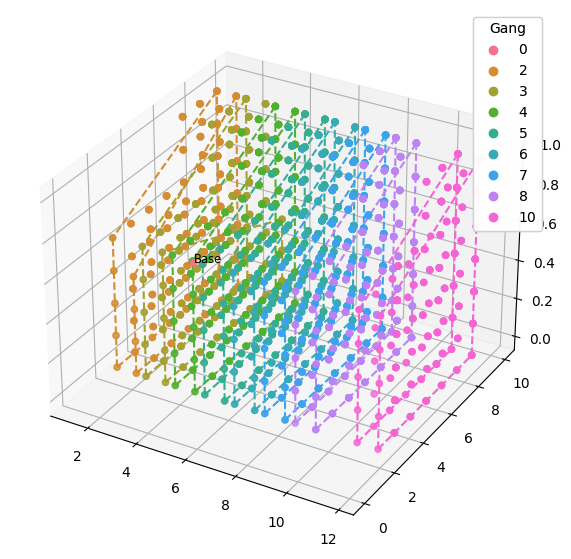

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


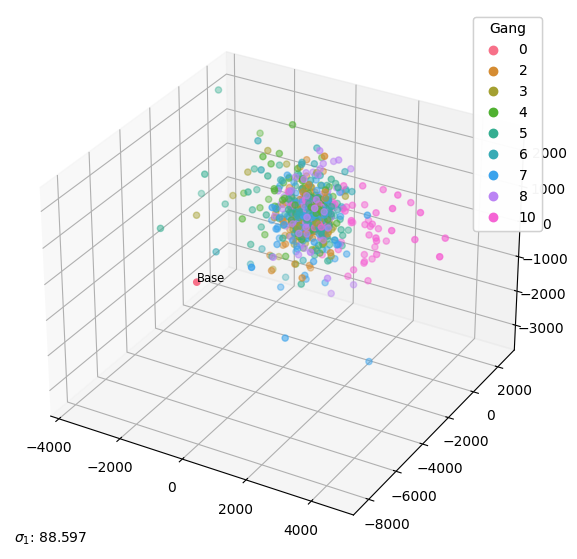

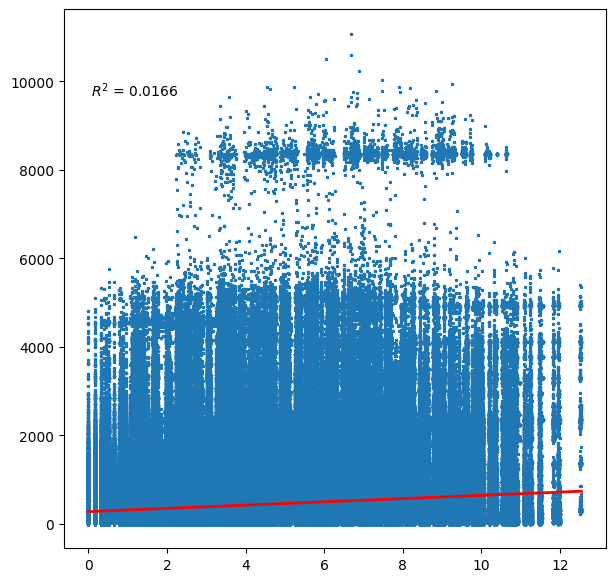

In [11]:
df_prod, data_prod, precomputed_data_prod, meta_data_prod = prepare_data(df_prod)
weights = my_mds.weights_due_to_num_observation(df_prod, max_observations=20)
init_configuration_prod = get_init_configuration(data_prod, meta_data_prod, data_model ='production')
metrics_prod = plot_and_compute_mds_configuration(df_prod, precomputed_data_prod, init_configuration_prod, meta_data_prod, 
                                                 weight_function=my_mds.weights_due_to_aisle_changes, 
                                                 old_weights=weights, 
                                                 shepard=True, 
                                                 weight_factor=0.1)

### Simulationsmodell-Modell mit ca. 500 Lagerplätze

In [12]:
df_sim = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_return_all.pkl')
wp_sim = my_mds.get_num_wp_according_locations(df_sim)
wp_sim


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                               127762

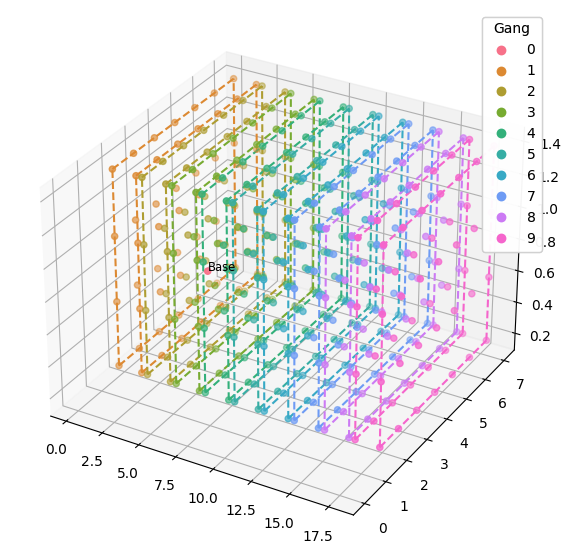

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


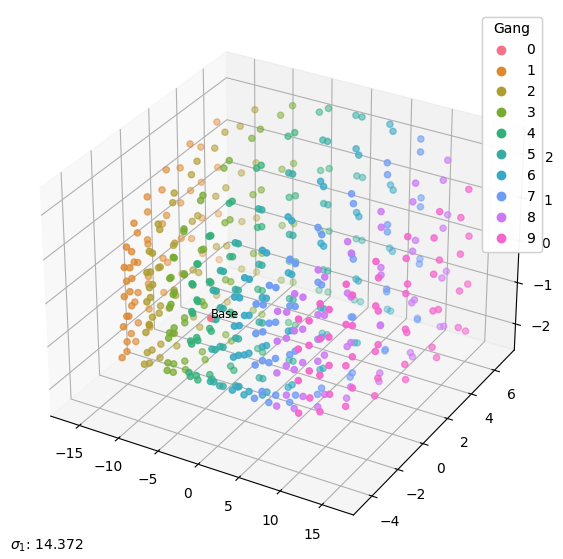

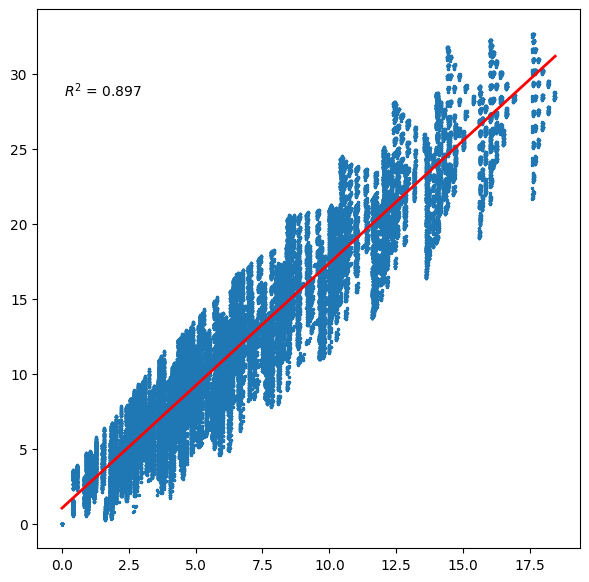

In [13]:
df_sim, data_sim, precomputed_data_sim, meta_data_sim= prepare_data(df_sim, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim, meta_data_sim, data_model ='simulation', aisle=9)
metrics_sim = plot_and_compute_mds_configuration(df_sim, precomputed_data_sim, init_configuration_aisle_9, meta_data_sim, 
                                                weight_function=my_mds.weights_due_to_aisle_changes, 
                                                plot_line=False, 
                                                shepard=True,
                                                weight_factor=0)


### Parameter der Modelle

In [14]:
import pandas as pd
import numpy as np

columns = ['Modell', '$IK$', '$w_{\rm Art_1}$','$w_{\rm f_1}$', '$w_{\rm Art_2}$', '$w_{\rm f_2}$']
test_model =  np.array(['Test-Modell', '-', '-','-', '-', '-'])
sim_model_16 = np.array(['Simulations-Modell k.', 'Blender-Koordinaten', '-','-', '-','-'])
prod_model = np.array(['Produktions-Modell', 'generiert über Metainformationen', 'Anzahl Beobachtungen','$max_{Beobachtungen} = 20$', 'Gangwechsel', 0])
sim_model = np.array(['Simulations-Modell',  'Blender-Koordinaten', 'Gangwechsel',0, '-','-'])

parameter_rq1 = pd.DataFrame(data=np.array([test_model, sim_model_16, prod_model, sim_model]), columns=columns)

In [15]:
styler = parameter_rq1.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Parameter der MDS Modelle", label="tab:param_rqs1"))

### Ergebnisse im Vergleich

In [16]:
import pandas as pd
import numpy as np

columns = ['Modell', '$\sigma_1$', '$R^2$', '$n\ LP$ ', '$n\ WP_{\rm max}$', '$n\ WP_{\rm ist}$', '$n\ RE']
test_model =  np.array(['Test-Modell', metrics_test[0], metrics_test[1], data_test.shape[0],data_test.shape[0]**2, data_test.shape[0]**2, '-'])
sim_model_16 = np.array(['Simulations-Modell $n_{\rm P}=16$', metrics_sim_16[0],metrics_sim_16[1], wp_sim_16.iloc[0,0],wp_sim_16.iloc[0,1], wp_sim_16.iloc[0,2],wp_sim_16.iloc[0,0]])
prod_model = np.array(['Produktions-Modell', metrics_prod[0], metrics_prod[1], wp_prod.iloc[0,0],wp_prod.iloc[0,1], wp_prod.iloc[0,2], data_prod.groupby(['aisle','shelf'], as_index = False).agg({'level': 'max'}).sum()[2]])
sim_model = np.array(['Simulations-Modell', metrics_sim[0], metrics_sim[1], wp_sim.iloc[0,0],wp_sim.iloc[0,1], wp_sim.iloc[0,2],wp_sim.iloc[0,0]])

result_rq1 = pd.DataFrame(data=np.array([test_model, sim_model_16, prod_model, sim_model]), columns=columns)

In [17]:
styler = result_rq1.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Bewertungsmatrix der Forschungsfrage", label="tab:res_rqs1"))

## RQ 1.1
*Inwieweit haben fehlende Wegverbindungen zwischen den Lagerplätzen Auswirkungen auf die Rekonstruktion?*

Zur Analyse werden drei Simulationsmodelle verglichen die unterschiedlich wiele Wegverbindungen aufweisen.

In [18]:
df_sim_100k = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_return_100000.pkl')
wp_sim_100k = my_mds.get_num_wp_according_locations(df_sim_100k)
wp_sim_100k


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                                85628

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


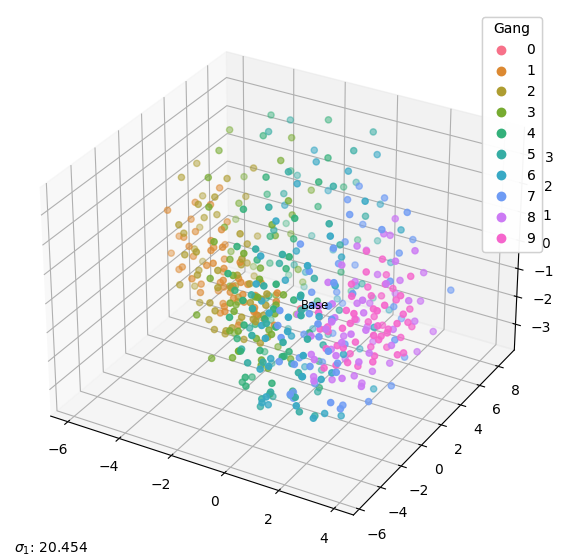

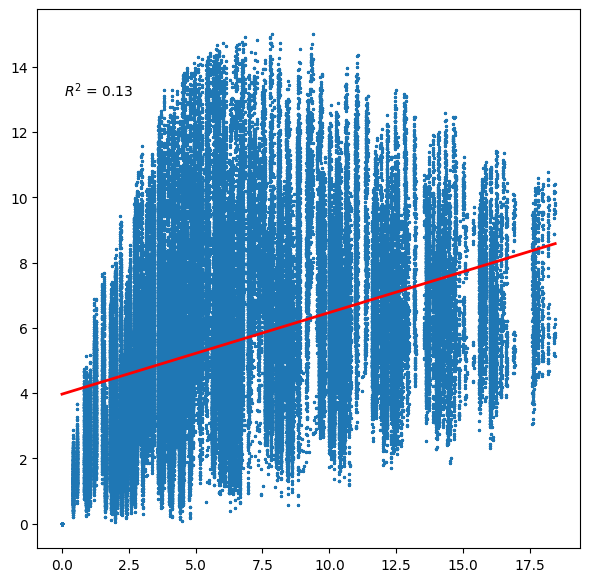

In [19]:
df_sim_100k, data_sim_100k, precomputed_data_sim_100k, meta_data_sim_100k = prepare_data(df_sim_100k, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim_100k, meta_data_sim_100k, data_model ='simulation', aisle=9, plot=False)
metrics_sim_100k = plot_and_compute_mds_configuration(df_sim_100k, precomputed_data_sim_100k, init_configuration_aisle_9, meta_data_sim_100k, 
                                                weight_function=my_mds.weights_due_to_aisle_changes, 
                                                plot_line=False, 
                                                shepard=True,
                                                weight_factor=0)


In [20]:
df_sim_250k = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_return_250000.pkl')
wp_sim_250k = my_mds.get_num_wp_according_locations(df_sim_250k)
wp_sim_250k


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                                96303

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


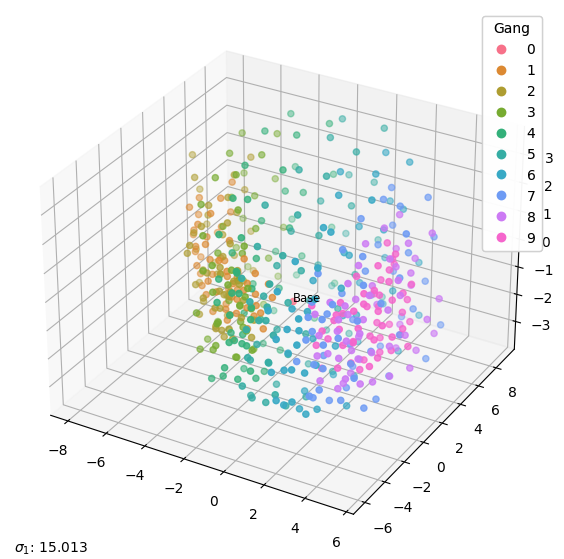

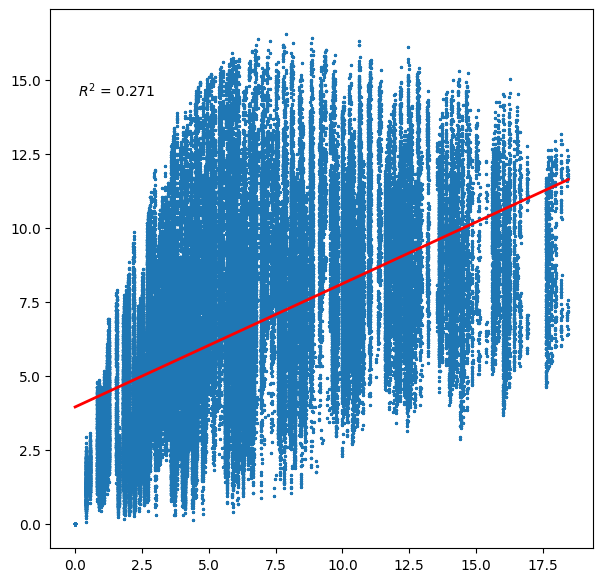

In [21]:
df_sim_250k, data_sim_250k, precomputed_data_sim_250k, meta_data_sim_250k = prepare_data(df_sim_250k, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim_250k, meta_data_sim_250k, data_model ='simulation', aisle=9, plot=False)
metrics_sim_250k = plot_and_compute_mds_configuration(df_sim_250k, precomputed_data_sim_250k, init_configuration_aisle_9, meta_data_sim_250k, 
                                                weight_function=my_mds.weights_due_to_aisle_changes, 
                                                plot_line=False, 
                                                shepard=True,
                                                weight_factor=0)


In [22]:
df_sim_all = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_return_all.pkl')
wp_sim_all = my_mds.get_num_wp_according_locations(df_sim_all)
wp_sim_all


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                               127762

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


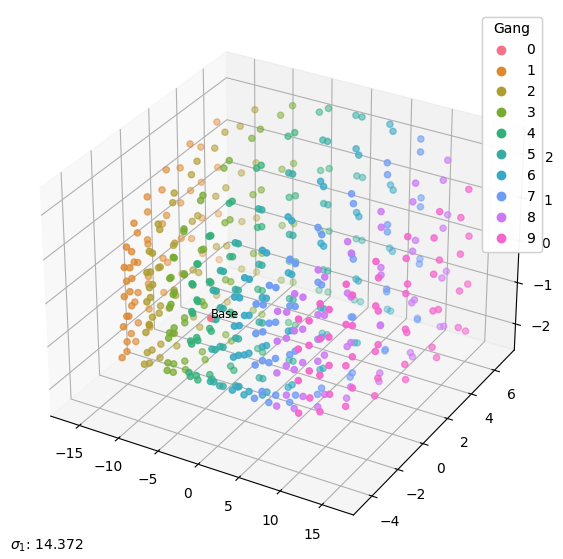

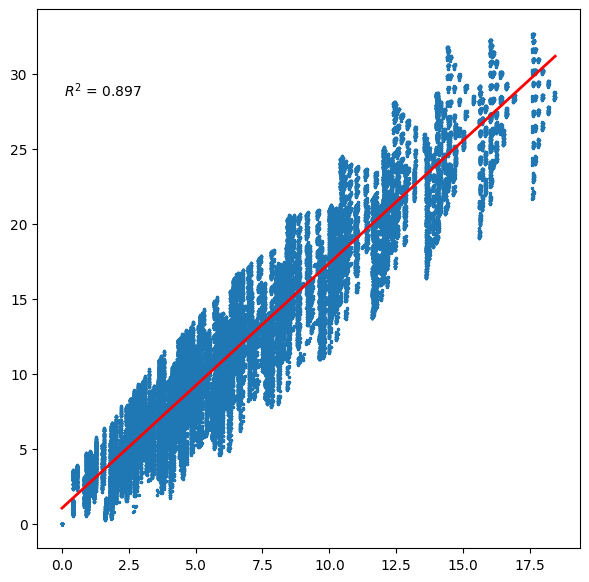

In [23]:
df_sim_all, data_sim_all, precomputed_data_sim_all, meta_data_sim_all = prepare_data(df_sim_all, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim_all, meta_data_sim_all, data_model ='simulation', aisle=9, plot=False)
metrics_sim_all = plot_and_compute_mds_configuration(df_sim_all, precomputed_data_sim_all, init_configuration_aisle_9, meta_data_sim_all, 
                                                weight_function=my_mds.weights_due_to_aisle_changes, 
                                                plot_line=False, 
                                                shepard=True,
                                                weight_factor=0)


### Parameter der Modelle

In [24]:
import pandas as pd
import numpy as np

columns = ['Modell', '$IK$', '$w_{rm Art}$','$w_{rm f}$', '$n_{rm KV}$']
sim_model_100k = np.array(['1. Simulations-Modell',   'Blender-Koordinaten', 'Gangwechsel',0, 100000])
sim_model_250k = np.array(['2. Simulations-Modell', 'Blender-Koordinaten', 'Gangwechsel',0, 250000])
sim_model_all = np.array(['3. Simulations-Modell',  'Blender-Koordinaten', 'Gangwechsel',0, '$infty$'])

parameter_rq11 = pd.DataFrame(data=np.array([sim_model_100k, sim_model_250k, sim_model_all]), columns=columns)

In [25]:
styler = parameter_rq11.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Parameter der MDS Modelle", label="tab:param_rqs1"))

### Ergebnisse im Vergleich

In [26]:
import pandas as pd
import numpy as np

columns = ['Modell', '$sigma_1$', '$R^2$', '$n_{rm P}$', '$n_{rm max}\ {P_i to P_j}$', '$n_{rm ist}\ {P_i to P_j}$']
sim_model_100k = np.array(['1. Simulations-Modell', metrics_sim_100k[0], metrics_sim_100k[1], wp_sim_100k.iloc[0,0],wp_sim_100k.iloc[0,1], wp_sim_100k.iloc[0,2]])
sim_model_250k = np.array(['2. Simulations-Modell', metrics_sim_250k[0],metrics_sim_250k[1], wp_sim_250k.iloc[0,0],wp_sim_250k.iloc[0,1], wp_sim_250k.iloc[0,2]])
sim_model_all = np.array(['3. Simulations-Modell', metrics_sim_all[0],metrics_sim_all[1], wp_sim_all.iloc[0,0],wp_sim_all.iloc[0,1], wp_sim_all.iloc[0,2]])

result_rq11 = pd.DataFrame(data=np.array([sim_model_100k, sim_model_250k, sim_model_all]), columns=columns)

In [27]:
styler = result_rq11.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Bewertungsmatrix der Forschungsfrage", label="tab:res_rqs1"))

## RQ 1.2
*Inwieweit beeinflussen unterschiedliche Bewegungsstrategien eine Rekonstruktion?*

Zur Analyse werden zwei Simulationsmodelle mit unterschielicher Strategie verglichen

In [28]:
df_sim_return = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_return_all.pkl')
wp_sim_return = my_mds.get_num_wp_according_locations(df_sim_return)
wp_sim_return


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                               127762

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


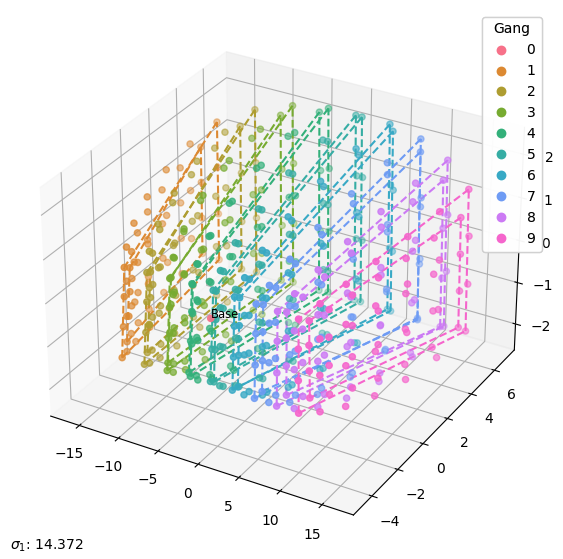

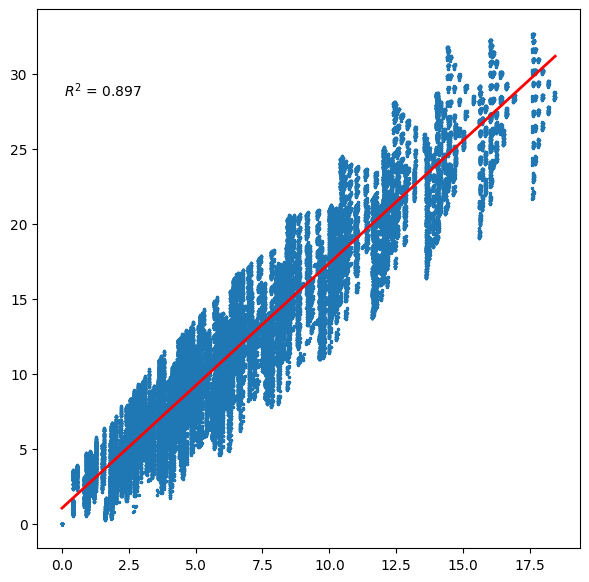

In [29]:
df_sim_return, data_sim_return, precomputed_data_sim_return, meta_data_sim_return = prepare_data(df_sim_return, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim_return, meta_data_sim_return, data_model ='simulation', aisle=9, plot=False)
metrics_sim_return = plot_and_compute_mds_configuration(df_sim_return, precomputed_data_sim_return, init_configuration_aisle_9, meta_data_sim_return, 
                                                weight_function=my_mds.weights_due_to_aisle_changes, 
                                                plot_line=True, 
                                                shepard=True,
                                                weight_factor=0)


In [30]:
df_sim_snake = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_snake_all.pkl')
wp_sim_snake = my_mds.get_num_wp_according_locations(df_sim_snake)
wp_sim_snake


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                               127762

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


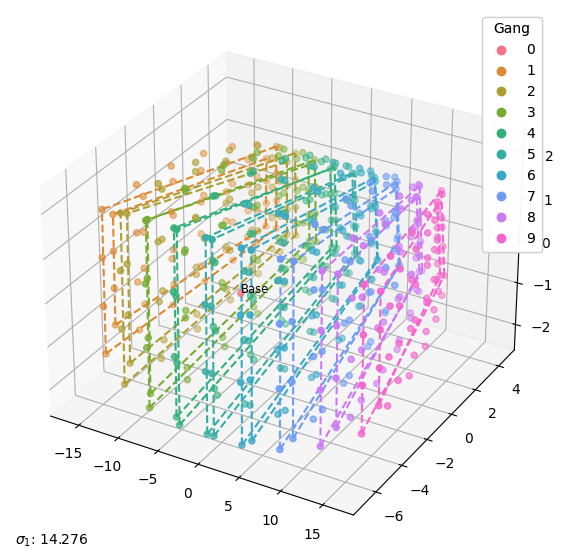

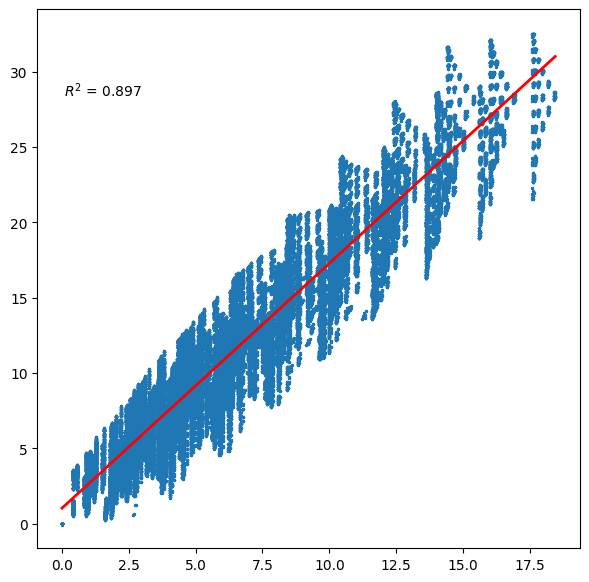

In [31]:
df_sim_snake, data_sim_snake, precomputed_data_sim_snake, meta_data_sim_snake = prepare_data(df_sim_snake, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim_snake, meta_data_sim_snake, data_model ='simulation', aisle=9, plot=False)
metrics_sim_snake = plot_and_compute_mds_configuration(df_sim_snake, precomputed_data_sim_snake, init_configuration_aisle_9, meta_data_sim_snake, 
                                                weight_function=my_mds.weights_due_to_aisle_changes, 
                                                plot_line=True, 
                                                shepard=True,
                                                weight_factor=0)


### Parameter der Modelle

In [32]:
import pandas as pd
import numpy as np

columns = ['Modell', '$IK$', '$w_{rm Art}$','$w_{rm f}$', 'Strategie']
sim_model_return = np.array(['1. Simulations-Modell', 'Blender-Koordinaten', 'Gangwechsel',0, 'Stichgang'])
sim_model_snake = np.array(['2. Simulations-Modell', 'Blender-Koordinaten', 'Gangwechsel',0,'Schleifen'])

parameter_rq12 = pd.DataFrame(data=np.array([sim_model_return, sim_model_snake]), columns=columns)

In [33]:
styler = parameter_rq12.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Parameter der MDS Modelle", label="tab:param_rqs1"))

### Ergebnisse im Vergleich

In [34]:
import pandas as pd
import numpy as np

columns = ['Modell', '$sigma_1$', '$R^2$', '$n_{rm P}$', '$n_{rm max}\ {P_i to P_j}$', '$n_{rm ist}\ {P_i to P_j}$', 'Strategie']
sim_model_return = np.array(['1. Simulations-Modell', metrics_sim_return[0], metrics_sim_return[1], wp_sim_return.iloc[0,0],wp_sim_return.iloc[0,1], wp_sim_return.iloc[0,2], 'Stichgang'])
sim_model_snake = np.array(['2. Simulations-Modell', metrics_sim_snake[0],metrics_sim_snake[1], wp_sim_snake.iloc[0,0],wp_sim_snake.iloc[0,1], wp_sim_snake.iloc[0,2], 'Schleifen'])

result_rq12 = pd.DataFrame(data=np.array([sim_model_return, sim_model_snake]), columns=columns)

In [35]:
styler = result_rq12.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Bewertungsmatrix der Forschungsfrage", label="tab:res_rqs1"))

## RQ 1.3
*Inwieweit haben Distanzen zwischen den Lagerplätzen, die eine Verzerrung über der tatsächlichen euklidischen Distanz vorweisen, Auswirkungen auf das Modell?*

Zur Analyse werden zwei Simulationsmodelle verglichen, wobei eines mit einer Gewichtung und das andere ohne Gewichtung parameterisiert ist

In [36]:
df_sim_weighted = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_snake_all.pkl')
wp_sim_weighted = my_mds.get_num_wp_according_locations(df_sim_weighted)
wp_sim_weighted


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                               127762

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


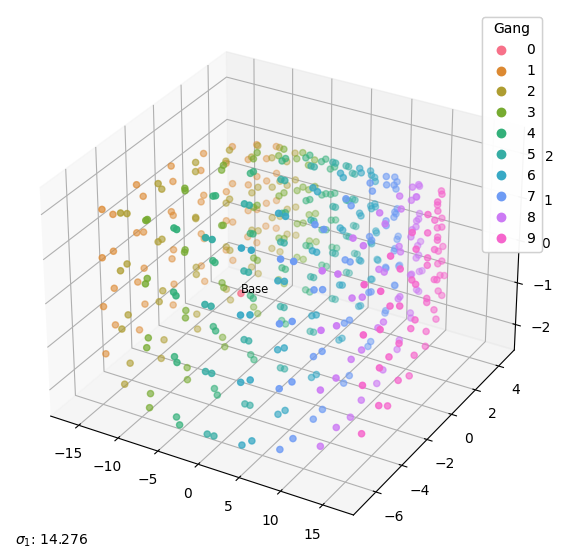

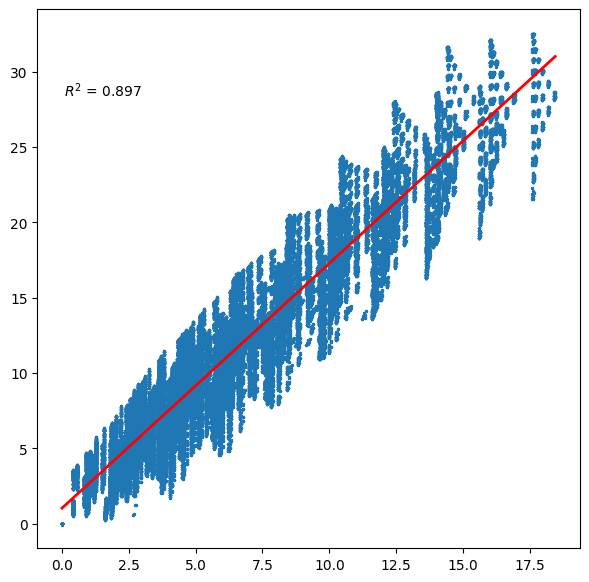

In [37]:
df_sim_weighted, data_sim_weighted, precomputed_data_sim_weighted, meta_data_sim_weighted = prepare_data(df_sim_weighted, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim_weighted, meta_data_sim_weighted, data_model ='simulation', aisle=9, plot=False)
metrics_sim_weighted = plot_and_compute_mds_configuration(df_sim_weighted, precomputed_data_sim_weighted, init_configuration_aisle_9, meta_data_sim_weighted, 
                                                weight_function=my_mds.weights_due_to_aisle_changes, 
                                                plot_line=False, 
                                                shepard=True,
                                                weight_factor=0)


In [38]:
df_sim_not_weighted = my_mds.import_pickle_dataset('data/simulation_data_9_aisle_snake_all.pkl')
wp_sim_not_weighted = my_mds.get_num_wp_according_locations(df_sim_not_weighted)
wp_sim_not_weighted


Anzahl Lagerplätze  Erwartete Anzahl an Wegverbindungen  \
0                 504                             127762.0   

   Anzahl tatsächliche Wegverbindungen  
0                               127762

/home/alexander/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:266: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


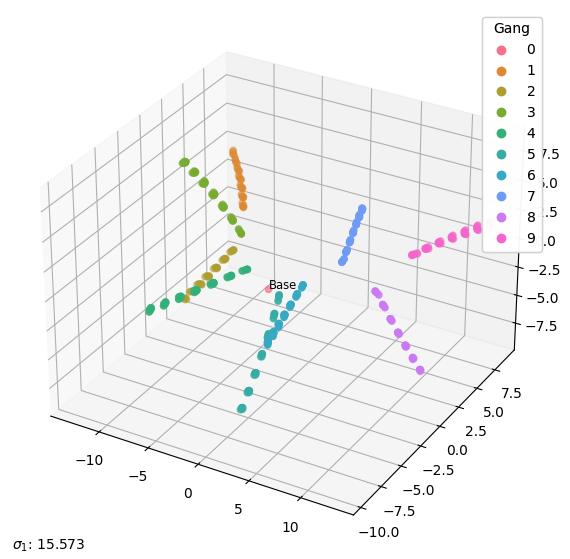

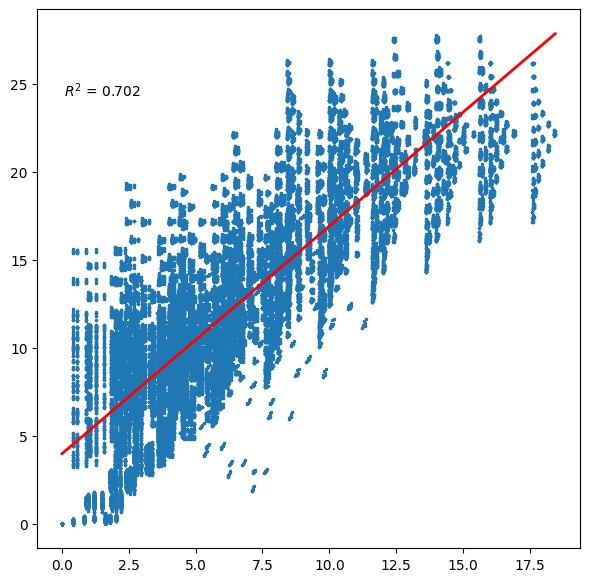

In [39]:
df_sim_not_weighted, data_sim_not_weighted, precomputed_data_sim_not_weighted, meta_data_sim_not_weighted = prepare_data(df_sim_not_weighted, data_model='simulation')
init_configuration_aisle_9 = get_init_configuration(data_sim_not_weighted, meta_data_sim_not_weighted, data_model ='simulation', aisle=9, plot=False)
metrics_sim_not_weighted = plot_and_compute_mds_configuration(df_sim_not_weighted, precomputed_data_sim_not_weighted, init_configuration_aisle_9, meta_data_sim_not_weighted, 
                                                weight_function=None, 
                                                plot_line=False, 
                                                shepard=True)


In [40]:
import pandas as pd
import numpy as np

columns = ['Modell', '$IK$', '$w_{rm Art}$','$w_{rm f}$']
sim_model_weighted = np.array(['1. Simulations-Modell', 'Blender-Koordinaten', 'Gangwechsel',0])
sim_model_not_weighted = np.array(['2. Simulations-Modell', 'Blender-Koordinaten', '-','-'])

parameter_rq13 = pd.DataFrame(data=np.array([sim_model_weighted, sim_model_not_weighted]), columns=columns)

In [41]:
styler = parameter_rq13.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Parameter der MDS Modelle", label="tab:param_rqs1"))

In [42]:
import pandas as pd
import numpy as np

columns = ['Modell', '$sigma_1$', '$R^2$', '$n_{rm P}$', '$n_{rm max}\ {P_i to P_j}$', '$n_{rm ist}\ {P_i to P_j}$']
sim_weighted = np.array(['1. Simulations-Modell', metrics_sim_weighted[0], metrics_sim_weighted[1], wp_sim_weighted.iloc[0,0],wp_sim_weighted.iloc[0,1], wp_sim_weighted.iloc[0,2]])
sim_not_weighted = np.array(['2. Simulations-Modell', metrics_sim_not_weighted[0],metrics_sim_not_weighted[1], wp_sim_not_weighted.iloc[0,0],wp_sim_not_weighted.iloc[0,1], wp_sim_not_weighted.iloc[0,2]])

result_rq13 = pd.DataFrame(data=np.array([sim_weighted, sim_not_weighted]), columns=columns)

In [43]:
styler = result_rq13.style
#styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.format(decimal=',', thousands='.', precision=2)
#styler.background_gradient(axis=None, cmap="gist_gray", gmap=-np.log(df_to_latex.values+1), vmin=-2)
styler.hide(axis="index")
styler.set_table_styles([
    {'selector': 'rowcolors', 'props': ':{1}{white}{lightgray};'}
], overwrite=False)

#print(styler.to_latex(multicol_align="c", hrules=True, convert_css=True, caption="Bewertungsmatrix der Forschungsfrage", label="tab:res_rqs1"))